In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

num GPUs 2
num GPUs 2


In [2]:
num_of_val = 24
image_size = 128

# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))
# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(27, 51, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

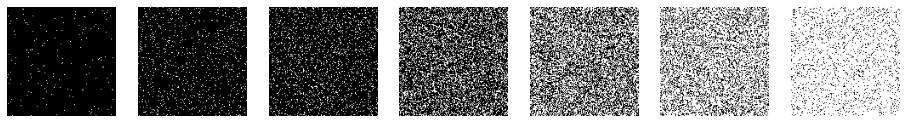

In [3]:
# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks_var = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks_var)):
    plt.subplot(1, len(masks_var), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks_var[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

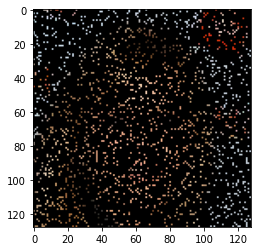

In [4]:
val_image, _, _ = val_set[1]
img_clean_var = val_image.view(-1, 3, 128, 128).to(device)

img_noisy_var = img_clean_var * masks_var[0]
img_noisy_np = var_to_np(img_noisy_var)

imgshow(img_noisy_var)

In [5]:
num_channels = [256]*3
net = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))
print(net)
rnd = 500
numit = 40000
rn = 0.005

number of parameters:  264960
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(scale_factor=2.0, mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(scale_factor=2.0, mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(scale_factor=2.0, mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(256, 256, kernel_size=

In [6]:
mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.002,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = masks_var[0],
                        find_best=True,
                        )

shape:  [1, 256, 16, 16]
optimize with adam 0.002


/home/hangdong/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(-0.5, 127.5, 127.5, -0.5)

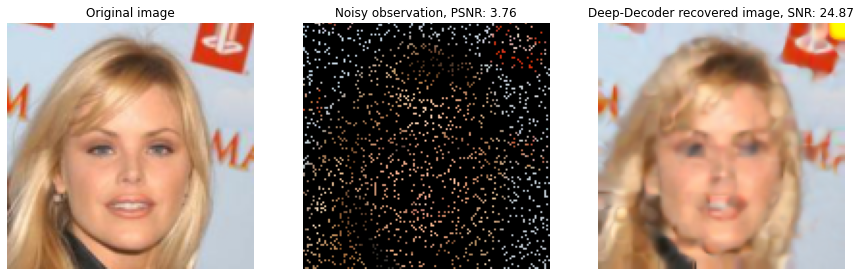

In [8]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var.detach()) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [4]:
def train_all_val(mask):
    
    def imgplot(img):
        plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
    # constant for training
    num_channels = [256]*3
    rnd = 500
    numit = 1700
    rn = 0.005
    psnr_list = []
    
    for i, (Xi_val, _, _) in enumerate(val_loader):
        progress = tqdm(total=1, desc='image % 3d' % i)
        
        img_clean_var = Xi_val.view(-1, 3, 128, 128).to(device) 
        net = decodernw(num_channels_up=num_channels, upsample_first = True).type(dtype)
        img_noisy_var = img_clean_var * mask
        
        mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.002,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask,
                        find_best=True,
                        )
        
        final_G = net( ni.type(dtype) )
        out_img_var = final_G.detach()
        
        imgplot(out_img_var)
        psnr_list.append(psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) )
        
        progress.set_postfix({'loss': loss_fn(final_G * mask, img_noisy_var).item()})
        progress.update()
        
    return np.mean(psnr_list)  

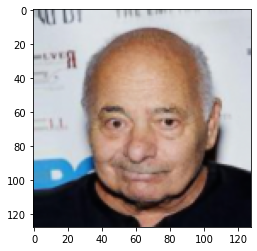

In [5]:
average_pnsr = []
for ratio, mask in zip(ratios, masks_var):
    print("for ratio:", ratio)
    snr = train_all_val(mask)
    average_pnsr.append(snr)
    print("psnr = ", snr)
    clear_output(wait=True)

[11.904032281201125, 15.335027713208218, 20.50280929965433, 31.111607866187303, 35.24971433970376, 38.34396487921627, 41.456362370688346]


Text(0.5, 1.0, 'deep decoder')

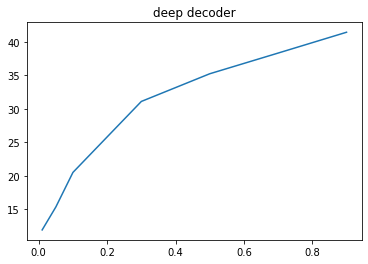

In [6]:
print(average_pnsr)
plt.plot(ratios, average_pnsr)
plt.title('deep decoder')

In [7]:
torch.cuda.current_device()

0